Importing dependencies

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import os

from tqdm.auto import tqdm

from src.dataset import FrameDataset
from src.utils import collate_fn, Averager
from src import config
hparams = config.hparams

Setting up datasets and dataloaders

In [2]:
generator = torch.Generator().manual_seed(42)
le = LabelEncoder()
le.fit(['abackground', 'bicycle','human', 'motorcycle', 'vehicle'])

dataset = FrameDataset(root = hparams.data, label_encoder = le)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2], generator=generator)

# training_data = FrameDataset(root = hparams.train_path, label_encoder = le)
# val_data = FrameDataset(root = hparams.val_path, label_encoder=le)

train_dataloader = DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=collate_fn)

In [10]:
with open('test_dataset.txt', 'w') as output:
    for idx in idx_list:
        output.write(str(dataset.img_files[idx] + '\n'))

Sanity checking data-loader

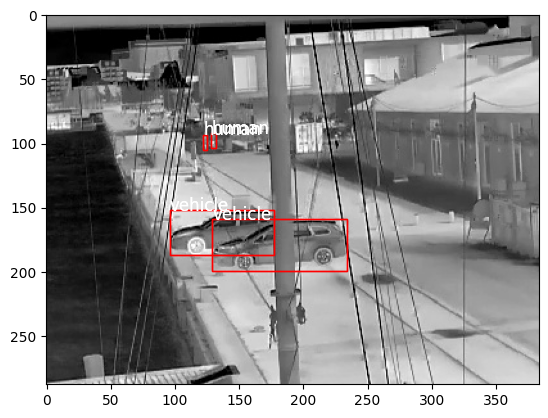

In [3]:
train_features, train_labels = next(iter(train_dataloader))#can check either train or val data
img = train_features[0].numpy().transpose(1, 2 , 0)
plt.imshow(img)

boxes = train_labels[0]['boxes'].numpy()
labels = train_labels[0]['labels'].numpy()
for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    label = le.inverse_transform([label])[0]
    plt.text(x1, y1, label, fontsize = 12, c='white')
    plt.gca().add_patch(Rectangle((x1,y1),(x2-x1),(y2-y1),
                    edgecolor='red',
                    facecolor='none',
                    lw=1))
    
plt.show()

Loading Faster R-CNN with a resnet50 backbone and training

In [4]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = torch.device('cuda')
model = fasterrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=hparams.num_classes) 

model.train()
model.to(device);

In [5]:
#Making sure output directory exists
output_dir = hparams.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [6]:
# #Optional to continue training from a checkpoint
# model = torch.load('products/epoch2checkpoint.pth')
# model.to(device)
# model.train();

Training Loop

In [7]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=hparams.learning_rate, momentum=0.9, weight_decay=0.00001)
train_loss_hist = Averager()
val_loss_hist = Averager()
best_valid_loss=float('inf')


for epoch in range(hparams.max_epochs):
    print(f"\nEPOCH {epoch+1} of {hparams.max_epochs}")
    train_loss_hist.reset()
    #Training step
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True)
    for frames, targets in prog_bar:
        
        frames = [frame.to(device) for frame in frames]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(frames, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   

    #Validation step
    val_loss_hist.reset()  
    
    prog_bar = tqdm(val_dataloader, total=len(val_dataloader), leave=True)
    for frames, targets in prog_bar:

        frames = [frame.to(device) for frame in frames]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(frames, targets) 
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        val_loss_hist.send(loss_value)      
     
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    #Saving best model
    if val_loss_hist.value < best_valid_loss:
        best_valid_loss = val_loss_hist.value
        print(f"\nBest validation loss: {best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch+1}\n")
    torch.save(model, os.path.join(hparams.output_dir, 'epoch' + str(epoch + 1) + '-best_model.pth'))
print('Training Complete')
             


EPOCH 1 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #1 train loss: 0.688


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #1 validation loss: 0.670

Best validation loss: 0.6701844167863408

Saving best model for epoch: 1


EPOCH 2 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #2 train loss: 0.690


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #2 validation loss: 0.699

EPOCH 3 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #3 train loss: 0.682


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #3 validation loss: 0.689

EPOCH 4 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #4 train loss: 0.667


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #4 validation loss: 0.658

Best validation loss: 0.6584164847340864

Saving best model for epoch: 4


EPOCH 5 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #5 train loss: 0.652


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #5 validation loss: 0.669

EPOCH 6 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #6 train loss: 0.639


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #6 validation loss: 0.648

Best validation loss: 0.6484531556031813

Saving best model for epoch: 6


EPOCH 7 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #7 train loss: 0.630


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #7 validation loss: 0.630

Best validation loss: 0.6302010108979165

Saving best model for epoch: 7


EPOCH 8 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #8 train loss: 0.621


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #8 validation loss: 0.622

Best validation loss: 0.622188275685302

Saving best model for epoch: 8


EPOCH 9 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #9 train loss: 0.613


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #9 validation loss: 0.624

EPOCH 10 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #10 train loss: 0.605


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #10 validation loss: 0.609

Best validation loss: 0.6093516082794954

Saving best model for epoch: 10


EPOCH 11 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #11 train loss: 0.599


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #11 validation loss: 0.616

EPOCH 12 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #12 train loss: 0.593


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #12 validation loss: 0.619

EPOCH 13 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #13 train loss: 0.587


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #13 validation loss: 0.605

Best validation loss: 0.6050865606928443

Saving best model for epoch: 13


EPOCH 14 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #14 train loss: 0.582


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #14 validation loss: 0.598

Best validation loss: 0.5976094607196889

Saving best model for epoch: 14


EPOCH 15 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #15 train loss: 0.575


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #15 validation loss: 0.584

Best validation loss: 0.5839757166116657

Saving best model for epoch: 15


EPOCH 16 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #16 train loss: 0.570


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #16 validation loss: 0.591

EPOCH 17 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #17 train loss: 0.566


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #17 validation loss: 0.586

EPOCH 18 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #18 train loss: 0.561


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #18 validation loss: 0.587

EPOCH 19 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #19 train loss: 0.557


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #19 validation loss: 0.586

EPOCH 20 of 20


  0%|          | 0/3113 [00:00<?, ?it/s]

Epoch #20 train loss: 0.552


  0%|          | 0/1038 [00:00<?, ?it/s]

Epoch #20 validation loss: 0.573

Best validation loss: 0.5731922707371971

Saving best model for epoch: 20

Training Complete
